# Sphere² Lamp

To run this Jupyter Notebook, install the required modules using:  
```pip install numpy vpython```

## Spherical geometry
The geometry of the Sphere² Lamp is based on a [Goldberg-Polyeder](http://www.3doro.de/kupp_5-6.htm) with 122 faces as shown in figure 1. The characteristic lengths on its surface needed for construction are given below.

In [1]:
import numpy as np
from math import *

In [2]:
R = 25/2 # Radius of the main sphere (in cm)
r = 4/2  # Radius of the balls on it (in cm)

In [3]:
# distances as in Fig. 1 in cm (calculated using half-side formula)
alpha = 2*pi/5
a = 2*R*atan(sqrt(1-2*cos(alpha)))
b = 2*R*atan(sqrt(-(cos((pi+3*alpha)/4)*cos((pi-alpha)/4))/(cos((3*alpha-pi)/4)*cos((alpha+pi)/4))))
h = 2*R*atan(sqrt(-(cos(alpha/2)-cos(pi/6))/(cos(alpha/2)+cos(pi/6))))

print(f'a = {a/R:.3f} R = {a:5.2f} cm')
print(f'b = {b/R:.3f} R = {b:5.2f} cm')
print(f'h = {h/R:.3f} R = {h:5.2f} cm')

a = 1.107 R = 13.84 cm
b = 1.017 R = 12.72 cm
h = 0.365 R =  4.56 cm


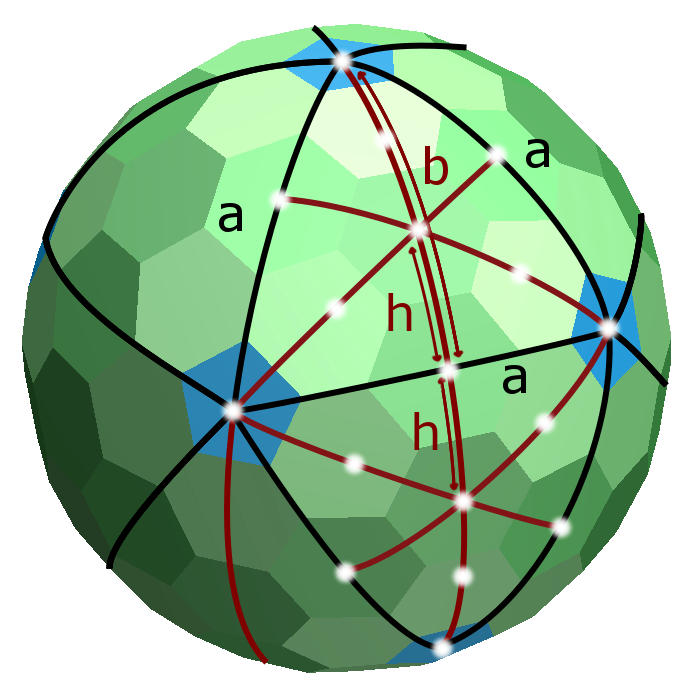  
Figure 1.: [Goldberg-Polyeder](http://www.3doro.de/kupp_5-6.htm) with 122 faces, specifically the Class II (2,2) polyhedra with geometrical grid and some exemplary LED positions (white dots)

## LED positions
The positions of the LEDs are calculated in terms of spherical coordinates. Stored as 8bit values, they are used by the microcontroller to create the animations.

In [4]:
# conversion between cartesian and spherical coordinates

def xyz(theta, phi, R=1):#, full_angle=2*pi):
    """Calculate cartesian from spherical coordinates"""
    #theta *= 2*pi/full_angle
    #phi *= 2*pi/full_angle
    x = R * sin(theta) * sin(phi)
    y = R * sin(theta) * cos(phi)
    z = R * cos(theta)
    return np.array((x, y, z))

def theta_phi(x, y, z):#, full_angle=2*pi):
    """Calculate spherical from cartesian coordinates"""
    R = sqrt(x**2 + y**2 + z**2)
    theta = acos(z/R)
    phi = atan2(x/R/sin(theta), y/R/sin(theta)) if sin(theta) != 0 else 0
    #theta *= full_angle/2*pi  # 0 .. full_angle/2
    #phi *= full_angle/2*pi  # -full_angle/2 .. +full_angle/2
    return np.array((theta, phi))

In [5]:
# calculate coordinates of all LEDs

THETA_PHI = []

def add(*, theta = None, phi = None, xyz = None):
    if theta is not None and phi is not None:
        THETA_PHI.append((theta, (phi+pi)%(2*pi)-pi))
    elif xyz is not None:
        THETA_PHI.append(theta_phi(*xyz))
    else:
        raise ValueError()


# north pole (1 ball)
add(theta=0, phi=0)
# 1st ring (5 balls)
for i in range(5):
    add(theta=(b-h)/2/R, phi=2*pi*(i+1.5)/5)
# 2nd ring (10 balls)
for i in range(5):
    add(theta=(b-h)/R, phi=2*pi*(i+0.5)/5)
    add(theta=a/R/2, phi=2*pi*(i+1)/5)
# 3rd ring (20 balls)
for i in range(5):
    p1 = xyz(theta=a/R, phi=2*pi*i/5)
    p2 = xyz(theta=(b-h)/R, phi=2*pi*(i+0.5)/5)
    p3 = xyz(theta=a/R, phi=2*pi*(i+1)/5)
    add(xyz=(p1+p2)/np.linalg.norm(p1+p2)*R)
    add(theta=b/R, phi=2*pi*(i+0.5)/5)
    add(xyz=(p2+p3)/np.linalg.norm(p2+p3)*R)
    add(xyz=p3)
# 4th ring (20 balls)
for i in range(5):
    p1 = xyz(theta=a/R, phi=2*pi*i/5)
    p2 = xyz(theta=(b+h)/R, phi=2*pi*(i+0.5)/5)
    p3 = xyz(theta=a/R, phi=2*pi*(i+1)/5)
    add(xyz=(p1+p2)/np.linalg.norm(p1+p2)*R)
    add(xyz=p2)
    add(xyz=(p2+p3)/np.linalg.norm(p2+p3)*R)
    add(theta=(a+(b-h)/2)/R, phi=2*pi*(i+1)/5)
    
# 5th ring at equator (10 balls)
for i in range(10):
    add(theta=pi/2, phi=2*pi*(i+0.5)/10)
    
# 6th ring (20 balls)
for i in range(5):
    p1 = xyz(theta=pi-(b+h)/R, phi=2*pi*i/5)
    p2 = xyz(theta=pi-a/R, phi=2*pi*(i+0.5)/5)
    p3 = xyz(theta=pi-(b+h)/R, phi=2*pi*(i+1)/5)
    add(xyz=p1)
    add(xyz=(p1+p2)/np.linalg.norm(p1+p2)*R)
    add(theta=pi-(a+(b-h)/2)/R, phi=2*pi*(i+0.5)/5)
    add(xyz=(p2+p3)/np.linalg.norm(p2+p3)*R)
# 7th ring (20 balls)
for i in range(5):
    p1 = xyz(theta=pi-(b-h)/R, phi=2*pi*i/5)
    p2 = xyz(theta=pi-a/R, phi=2*pi*(i+0.5)/5)
    p3 = xyz(theta=pi-(b-h)/R, phi=2*pi*(i+1)/5)    
    add(theta=pi-b/R, phi=2*pi*i/5)
    add(xyz=(p1+p2)/np.linalg.norm(p1+p2)*R)
    add(xyz=p2)
    add(xyz=(p2+p3)/np.linalg.norm(p2+p3)*R)
# 8th ring (10 balls)
for i in range(5):
    add(theta=pi-(b-h)/R, phi=2*pi*i/5)
    add(theta=pi-a/R/2, phi=2*pi*(i+0.5)/5)
# 9th ring (5 balls)
for i in range(5):
    add(theta=pi-(b-h)/2/R, phi=2*pi*i/5)
# south pole (1 ball)
add(theta=pi, phi=0)


THETA, PHI = np.array(THETA_PHI).T

# indices for pentagon symmetry
PENT_A = [0, 19,23,27,31,35,  88,92,96,100,104, 121] # balls with 5 neighbors
PENT_B = [1,2,3,4,5, 16,18,20,22,24,26,28,30,32,34,36,38,39,40,42,43,44,46,47,48,50,51,52,54,55, 67,68,69,71,72,73,75,76,77,79,80,81,83,84,85,87,89,91,93,95,97,99,101,103,105, 116,117,118,119,120] # these neighbors
PENT_C = [6,7,8,9,10,11,12,13,14,15,17,21,25,29,33,37,41,45,49,53,56,57,58,59,60,61,62,63,64,65,66,70,74,78,82,86,90,94,98,102,106,107,108,109,110,111,112,113,114,115] # others

The following code snipped can be copied to the C code

In [6]:
NUM_LEDS = len(THETA_PHI)
THETA8 = np.round(THETA*255/pi).astype('uint8')
PHI8 = np.round((PHI+pi)*255/2/pi).astype('uint8')

print(f'#define NUM_LEDS    {NUM_LEDS}')
print('\n// theta = angle from north pole (0) to south pole (255)')
print('static uint8_t THETA[NUM_LEDS] = {'+','.join([f'{i}' for i in THETA8])+'};')
print('\n// phi = angle around vertical axis from 0 to 255')
print('static uint8_t PHI[NUM_LEDS] = {'+','.join([f'{i}' for i in PHI8])+'};')

#define NUM_LEDS    122

// theta = angle from north pole (0) to south pole (255)
static uint8_t THETA[NUM_LEDS] = {0,26,26,26,26,26,53,45,53,45,53,45,53,45,53,45,69,83,69,90,69,83,69,90,69,83,69,90,69,83,69,90,69,83,69,90,100,112,100,116,100,112,100,116,100,112,100,116,100,112,100,116,100,112,100,116,128,128,128,128,128,128,128,128,128,128,143,155,139,155,143,155,139,155,143,155,139,155,143,155,139,155,143,155,139,155,172,186,165,186,172,186,165,186,172,186,165,186,172,186,165,186,172,186,165,186,202,210,202,210,202,210,202,210,202,210,229,229,229,229,229,255};

// phi = angle around vertical axis from 0 to 255
static uint8_t PHI[NUM_LEDS] = {128,204,0,51,102,153,153,178,204,230,0,26,51,76,102,128,138,153,168,178,189,204,219,230,240,0,15,26,36,51,66,76,87,102,117,127,141,153,165,178,192,204,216,230,243,255,12,26,39,51,63,76,90,102,114,128,140,166,191,217,242,13,38,64,89,115,128,140,153,166,178,191,204,217,230,242,0,13,26,38,51,64,76,89,102,115,128,143,153,163,178,194,204,214,230,245,2

## Interactive 3D model
This interactive 3D model of the Sphere² Lamp can be used to help wireing the LEDs in the correct order and to design animations.

In [7]:
import vpython as vp

<IPython.core.display.Javascript object>

In [8]:
scene = vp.canvas(title='', background=vp.color.white, width=400, height=400)
scene.caption = 'Figure 2.: Interactive model of the Sphere² Lamp. Use right mouse button to rotate and mouse wheel to zoom.\n'
# save screenshots with firefox console command:      :screenshot --selector ".glowscript-canvas-wrapper"

<IPython.core.display.Javascript object>

In [9]:
# setup scene camera position
def reset_view(m=None):
    scene.center = vp.vector(0, 0, 0)
    scene.forward = vp.vector(*xyz(3/4*pi, -3/4*pi, R))
    scene.up = vp.vector(0, 0, 1)
    scene.fov = pi/10
    scene.range = 1.5*R
    
def save_view(m=None):
    # does not include labels, see https://github.com/vpython/vpython-jupyter/issues/152
    # as an alternative, type the following in firefox's console:
    #     :screenshot --selector ".glowscript-canvas-wrapper"
    scene.capture('sphere2-lamp.png')

scene.append_to_caption('\n')
vp.button(text='Reset view', bind=reset_view)
vp.button(text='Save as image', bind=save_view)

reset_view()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# add sphere
vp.sphere(radius=R, pickable=False, shininess = 0)
vp.cylinder(radius=R*1.01, axis=vp.vector(0,0,R/100), color=vp.color.black, opacity=0.5)
vp.cone(pos=vp.vector(0,0,-2.5*R), radius=R/5, axis=vp.vector(0,0,R), color=vp.color.black)

# add balls
balls, labels = [], []
for i, (theta, phi) in enumerate(THETA_PHI):
    balls.append(vp.sphere(pos=vp.vector(*xyz(theta, phi, R)), radius=r, shininess = 0, #emissive=True,
                           color=vp.color.hsv_to_rgb(vp.vector(3/5 if i in PENT_A else 2/5 if i in PENT_B else 1/5,1,1))))
    labels.append(vp.label(pos=vp.vector(*xyz(THETA[i], PHI[i], R+r/2)), text=i+1, visible=False, 
                           box=False, opacity=0, color=vp.color.white))

# LED positions and wires
positions = vp.points(pos=[b.pos for b in balls], radius=3, color=vp.color.black, opacity=0.5) # radius in px
wires = vp.curve(pos=[b.pos for b in balls], radius=r/10, color=vp.color.red, shininess=0, visible=False)

In [11]:
# show/hide
def menu_showballs(m):
    for b, l in zip(balls, labels):
        b.visible = m.checked
        l.color = vp.color.white if m.checked else vp.color.black
def menu_showwires(m):
    wires.visible = m.checked
scene.append_to_caption('\n')
vp.checkbox(text='Show balls     ', checked=True, bind=menu_showballs)
vp.checkbox(text='Show wires', checked=False, bind=menu_showwires)

In [12]:
# show numbering
def number_on_mouse(evt):
    obj = scene.mouse.pick
    if obj in balls:
        lab = labels[balls.index(obj)]
        lab.visible = not lab.visible

def menu_numbers(m):
    scene.unbind('click', number_on_mouse)
    
    if m.index == 1: # Top front
        scene.forward = vp.vector(*xyz(3/4*pi, -3/4*pi, R))
        for i, label in enumerate(labels):
            label.visible = -pi/4 < PHI[i] < pi*3/4 and i < 66 or i < 16
    elif m.index == 2: # Top back
        scene.forward = vp.vector(*xyz(3/4*pi, -3/4*pi+pi, R))
        for i, label in enumerate(labels):
            label.visible = not (-pi/4 < PHI[i] < pi*3/4) and i < 66 or i < 16
    elif m.index == 3: # Bottom back
        scene.forward = vp.vector(*xyz(3/4*pi, -3/4*pi, -R))
        for i, label in enumerate(labels):
            label.visible = not (-pi/4 < PHI[i] < pi*3/4) and i > 55 or i > 105
    elif m.index == 4: # Bottom front
        scene.forward = vp.vector(*xyz(3/4*pi, -3/4*pi+pi, -R))
        for i, label in enumerate(labels):
            label.visible = (-pi/4 < PHI[i] < pi*3/4) and i > 55 or i > 105
    elif m.index == 5: # On mouse hover
        scene.bind('click', number_on_mouse)
    else:
        scene.forward = vp.vector(*xyz(3/4*pi, -3/4*pi, R))
        for i, label in enumerate(labels):
            label.visible = False
            
            
scene.append_to_caption('\nShow LED numbers: ')       
vp.menu(choices=['None', 'Top front', 'Top back', 'Bottom back', 'Bottom front', 'On mouse click'], bind=menu_numbers)